In [113]:
from bs4 import BeautifulSoup
from selenium import webdriver
import selenium
from urllib.parse import  urlparse
import time
import lxml
from urllib.request import urlopen
from selenium.webdriver.common.keys import Keys
import numpy as np
import pandas as pd
import re
import pickle
from contextlib import suppress
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate, KFold
from tqdm import tqdm

from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier

In [296]:
ds_star = pd.read_csv("C:/690009/TP2/final_project/Project/Data/shopping_ds.csv")
ds_star

ds_star.drop_duplicates(subset=['type', 'review', 'star'], inplace=True)
ds_star

ds_star["label"] = 0
ds_star

,Unnamed: 0,type,review,star,label
0,0,아이패드,택배가 이렇게 왔네요 정말 어이가 없어서전자제픔인데 물건을 이렇게 배송해주셔 ...,1,0
2,2,아이패드,고장나서 옴 수리하기도 돈아까윰 기쁜 마음으로 개봉했는데 액정은 아니지만 뒷면...,1,0
4,4,아이패드,그냥 모든게 허접해요 일단 사용해 보지 않아서 성능 기능 모릅니다시 이전 당일...,1,0
6,6,아이패드,물건은 잘왔습니다 그런데 택배회사가 엉망이네요고가의 제품이라 배송전에 연락 ...,1,0
8,8,아이패드,대응이 정말 안좋아요 크리스마스 선물로 일 오전 결제했는데일날 도착해서 다 망...,1,0
...,...,...,...,...,...
25824,25824,아이패드,다시는 오픈마켓에서 안살거에요 ㅎㅎ ㅜ 공홈에서 사야 교환하기도 편하고 좋을거같네요,1,0
25825,25825,아이패드,선물용으로 산거라 교환할 시간도 없어서 그냥 줬는데 모서리 찍혀있더라구요. 리퍼제...,1,0
25826,25826,아이패드,배송개ㅈ같이느리네주문한지가언젠데ㅋㅋ욕먹고싶어해서욕박는다재고없음연락해서먼저 조치를취하...,1,0
25827,25827,아이패드,미안하지도 않나봐요?,1,0


In [297]:
# ds_star.set_index("", inplace=True)
ds_star.loc[ds_star["star"] > 3, "label"] = 1
ds_star

,Unnamed: 0,type,review,star,label
0,0,아이패드,택배가 이렇게 왔네요 정말 어이가 없어서전자제픔인데 물건을 이렇게 배송해주셔 ...,1,0
2,2,아이패드,고장나서 옴 수리하기도 돈아까윰 기쁜 마음으로 개봉했는데 액정은 아니지만 뒷면...,1,0
4,4,아이패드,그냥 모든게 허접해요 일단 사용해 보지 않아서 성능 기능 모릅니다시 이전 당일...,1,0
6,6,아이패드,물건은 잘왔습니다 그런데 택배회사가 엉망이네요고가의 제품이라 배송전에 연락 ...,1,0
8,8,아이패드,대응이 정말 안좋아요 크리스마스 선물로 일 오전 결제했는데일날 도착해서 다 망...,1,0
...,...,...,...,...,...
25824,25824,아이패드,다시는 오픈마켓에서 안살거에요 ㅎㅎ ㅜ 공홈에서 사야 교환하기도 편하고 좋을거같네요,1,0
25825,25825,아이패드,선물용으로 산거라 교환할 시간도 없어서 그냥 줬는데 모서리 찍혀있더라구요. 리퍼제...,1,0
25826,25826,아이패드,배송개ㅈ같이느리네주문한지가언젠데ㅋㅋ욕먹고싶어해서욕박는다재고없음연락해서먼저 조치를취하...,1,0
25827,25827,아이패드,미안하지도 않나봐요?,1,0


In [262]:
ds_star["review"] = ds_star['review'].str.replace("\n","")
ds_star["review"] = ds_star["review"].str.replace("[^a-zA-Z가-힣0-9 ]", "")

<ipython-input-262-f66e274aceb6>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  ds_star["review"] = ds_star["review"].str.replace("[^a-zA-Z가-힣0-9 ]", "")


In [263]:
ds_star.groupby(['star']).count()

,Unnamed: 0,type,review,label
star,,,,
1,1440,1440,1440,1440
2,896,896,896,896
3,3439,3439,3439,3439
4,7065,7065,7065,7065


In [264]:
train_data, test_data = train_test_split(ds_star, test_size=0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 9630
테스트용 리뷰의 개수 : 3210


In [265]:
train_data.drop_duplicates(subset=["review", "star"], inplace=True)
test_data.drop_duplicates(subset=["review", "star"], inplace=True)
print(len(train_data))
print(len(test_data))
1
train_data.drop_duplicates(subset=["review", "star"], inplace=True)
2
test_data.drop_duplicates(subset=["review", "star"], inplace=True)
3
print(len(train_data))
4
print(len(test_data))
10759

8958
3116
8958
3116


<ipython-input-265-4c326b2fd97c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop_duplicates(subset=["review", "star"], inplace=True)
<ipython-input-265-4c326b2fd97c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop_duplicates(subset=["review", "star"], inplace=True)
<ipython-input-265-4c326b2fd97c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop_duplicates(subset=["review", "star"], inpl

10759

<AxesSubplot:>

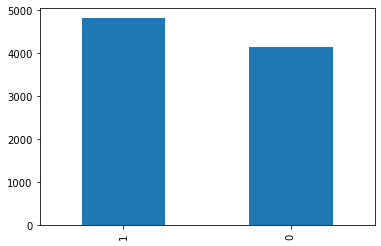

In [266]:
train_data['label'].value_counts().plot(kind = 'bar')

In [267]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0   4142
1      1   4816


In [268]:
print(train_data.isnull().values.any())

False


In [269]:
print(train_data.isnull().sum())

Unnamed: 0    0
type          0
review        0
star          0
label         0
dtype: int64


In [270]:
train_data.loc[train_data.review.isnull()]

,Unnamed: 0,type,review,star,label


In [271]:
train_data = train_data.dropna(how = 'any')
print(train_data.isnull().values.any())

False


In [272]:
print(len(train_data))

8958


In [273]:
train_data['review'] = train_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:5]

<ipython-input-273-9263ec25ae0b>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['review'] = train_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,Unnamed: 0,type,review,star,label
2729,2729,맥북,본품이랑펜은 먼저왔는데 악세서리들 배송이 많이 늦어서 아쉬웠어요 대한통운으로 ...,4,1
10270,10270,삼성전자 갤럭시 버즈 플러스,사고나니 할인쿠폰생겨서 내가 구입한 가격보다 만원이나 더싸졌네요딸기우유색깔 이뻐요노...,2,0
4244,4244,애플 에어팟 프로,아이폰쓰다 갤럭시로 몇년간 안드로이드적응되다보니 가 좀 헷갈리긴하는데 아이패...,4,1
7207,7207,삼성전자 갤럭시 버즈 라이브,엘지폰에 연결이 잘 안되네요,3,0
2041,2041,애플워치,배송이 오래 걸려서 좀 빛샘은 크게 나눠서 군데정도 있고 휨은 괜찮은데 찍힘이...,4,1


In [274]:
test_data.drop_duplicates(subset = ['review'], inplace=True) # 중복 제거
test_data['review'] = test_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['review'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 2918


<ipython-input-274-1f0ed5dc41ef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop_duplicates(subset = ['review'], inplace=True) # 중복 제거
<ipython-input-274-1f0ed5dc41ef>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['review'] = test_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
<ipython-input-274-1f0ed5dc41ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['review'] = test_data['review'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
C:\ProgramData\Anaconda3\lib\sit

In [275]:
train_data['review'] = train_data['review'].str.replace('^ +', "")
train_data['review'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

Unnamed: 0    0
type          0
review        8
star          0
label         0
dtype: int64


<ipython-input-275-e5b57724600d>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['review'] = train_data['review'].str.replace('^ +', "")


In [276]:
train_data.loc[train_data.review.isnull()][:5]

,Unnamed: 0,type,review,star,label
24571,24571,미밴드2,NaN,3,0
25756,25756,아이패드,NaN,3,0
24307,24307,미밴드2,NaN,4,1
23401,23401,에어닷,NaN,2,0
7727,7727,삼성전자 갤럭시 버즈 라이브,NaN,1,0


In [277]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

8950


In [278]:
okt = Okt()
stopwords = ['가','게','고','과','네','는','다','도','들','듯','를','에','와','으로',
             '은','을','의','이','인','임','자','잘','좀','지','하다','한']

In [279]:
X_train = []
for sentence in train_data['review']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [280]:
print(X_train[:3])

[['본', '품', '이랑', '펜', '먼저', '오다', '악세다', '서리', '배송', '많이', '늦다', '아쉽다', '대', '통운', '배송', '오다', '요즘', '대란', '이라', '그렇다', '한참', '인천', '빠지다', '오다', '아이폰', '사용', '익숙하다', '주문', '요', '금제', '안', '바꾸다', '안', '쓰리다', '급제', '폰', '선택', '비싸다', '많이', '기다리다', '배송', '빠르다', '너무', '좋다', '시간', '만에', '오다', '같다', '포장', '원하다', '색상', '구매', '너무', '좋다', '배송', '빨랏', '너무', '이쁘다', '쿠팡', '에서는', '알림', '해', '놓다', '매번', '실패하다', '운', '좋다', '여기', '서다', '바로', '구매', '수', '있다', '배송', '빠르다', '싸다', '가격', '만족하다', '자다', '도착', '만족하다', '배송', '빠르다', '진짜', '고민', '많이', '아직', '뭐', '백퍼센트', '활용', '못', '허세', '템', '좋다', '햐', '어', '요', '호호', '후후', '하하', '랄랄', '배송', '약간', '불안하다', '오다', '상태', '좋다', '로', '오다', '좋다', '약간', '빛번', '지다', '굳다', '굳다', '굳다', '굳다', '역시', '노트북', '맥북', '것', '같다', '년', '형', '이지만', '성능', '빠르다', '디자인', '자다', '받다', '저렴하다', '가격', '자다', '사다', '감사하다', '안전하다', '포장', '자다', '해', '보내다', '물건', '뭐', '넘다', '좋다', '건', '알다', '배송비', '아마', '넌', '싸다', '알', '쌋다', '들다', '눈티', '리콜', '제품', '이라', '찝찝하다', '타', '사이트', '판매', '가다', '비슷하다', '당

In [281]:
X_test = []
for sentence in test_data['review']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)
print(X_test[:3])

[['좋다', '빨르다', '가볍다', '예쁘다'], ['아이', '착용', '가볍다', '좋다'], ['배송', '빠르다', '좋다', '상품', '받다', '매우', '만족하다', '색도', '너무', '이쁘다', '케이스', '마음', '들다', '다만', '개인', '적', '필름', '붙이다', '조금', '힘들다', '저', '실패하다', '전적', '있다', '따로', '돈', '주다', '붙이다']]


In [282]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [283]:
print(tokenizer.word_index)

{'좋다': 1, '배송': 2, '받다': 3, '있다': 4, '자다': 5, '제품': 6, '보다': 7, '빠르다': 8, '사용': 9, '너무': 10, '되다': 11, '구매': 12, '로': 13, '같다': 14, '오다': 15, '없다': 16, '이다': 17, '안': 18, '쓰다': 19, '요': 20, '에서': 21, '않다': 22, '사다': 23, '가격': 24, '하고': 25, '만족하다': 26, '것': 27, '주문': 28, '때': 29, '만': 30, '상품': 31, '일': 32, '생각': 33, '들다': 34, '안되다': 35, '아니다': 36, '제': 37, '더': 38, '선물': 39, '월': 40, '가다': 41, '많이': 42, '기능': 43, '처음': 44, '되어다': 45, '괜찮다': 46, '포장': 47, '센터': 48, '정말': 49, '음질': 50, '저': 51, '그냥': 52, '이라': 53, '문제': 54, '구입': 55, '그렇다': 56, '아이폰': 57, '못': 58, '에어팟': 59, '써다': 60, '걸리다': 61, '조금': 62, '불량': 63, '저렴하다': 64, '감사하다': 65, '폰': 66, '서비스': 67, '예쁘다': 68, '아쉽다': 69, '케이스': 70, '이쁘다': 71, '이어폰': 72, '버즈': 73, '느리다': 74, '정도': 75, '애플': 76, '중': 77, '수': 78, '서': 79, '다른': 80, '택배': 81, '늦다': 82, '적': 83, '프로': 84, '충전': 85, '귀': 86, '거': 87, '해주다': 88, '고민': 89, '디자인': 90, '없이': 91, '소리': 92, '바로': 93, '해보다': 94, '모르다': 95, '교환': 96, '빨리': 97, '보내다': 98, '그': 99, '성능': 100, 

In [284]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 9620
등장 빈도가 2번 이하인 희귀 단어의 수: 4498
단어 집합에서 희귀 단어의 비율: 46.75675675675676
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.843860337387211


In [285]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 5123


In [286]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [287]:
print(X_train[:3])

[[665, 207, 263, 353, 694, 15, 2540, 2872, 2, 42, 82, 69, 254, 1558, 2, 15, 587, 2023, 53, 56, 892, 1764, 244, 15, 57, 9, 967, 28, 20, 1470, 18, 203, 18, 988, 1638, 66, 292, 181, 42, 103, 2, 8, 10, 1, 117, 149, 15, 14, 47, 374, 105, 12, 10, 1, 2, 2873, 10, 71, 606, 394, 627, 280, 641, 1260, 1307, 953, 1, 215, 340, 93, 12, 78, 4, 2, 8, 165, 24, 26, 5, 128, 26, 2, 8, 136, 89, 42, 106, 235, 3356, 713, 58, 2874, 2190, 1, 2402, 344, 20, 2686, 2687, 1639, 2688, 2, 268, 719, 15, 152, 1, 13, 15, 1, 268, 3729, 519, 588, 588, 588, 588, 122, 175, 355, 27, 14, 126, 216, 659, 100, 8, 90, 5, 3, 64, 24, 5, 23, 65, 252, 47, 5, 280, 98, 110, 235, 114, 1, 245, 116, 998, 1936, 3357, 165, 307, 3730, 34, 3731, 968, 6, 53, 908, 383, 370, 139, 41, 824, 435, 512, 1559, 53, 21, 12, 695, 7, 1341, 44, 12, 29, 40, 219, 15, 1191, 241, 31, 816, 40, 219, 672, 208, 3732, 22, 540, 151, 226, 720, 20, 59, 926, 278, 94, 271, 42, 3733, 215, 292], [23, 197, 494, 441, 258, 55, 24, 7, 274, 162, 38, 165, 4370, 628, 71, 175, 2

In [288]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [289]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [290]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

8947
8947


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 1141
리뷰의 평균 길이 : 33.27797026936403


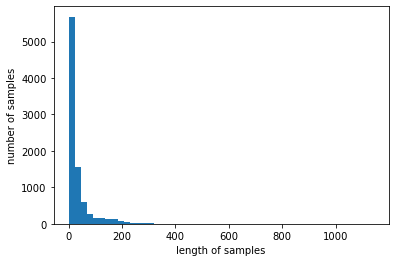

In [291]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [292]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [293]:
max_len = 100
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 100 이하인 샘플의 비율: 91.17022465630937


In [294]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [295]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_pred_ = []

for i in range(len(y_pred)):
    if y_pred[i][0] > 0.5:
        y_pred_.append(1)
    else:
        y_pred_.append(0)
y_pred_

confusion_matrix(y_test, y_pred_)

array([[ 839,  460],
       [1016,  603]], dtype=int64)

In [153]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [154]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [103]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
208/208 [==============================] - 52s 236ms/step - loss: 0.4895 - acc: 0.7756 - val_loss: 0.5049 - val_acc: 0.8039

Epoch 00001: val_acc improved from -inf to 0.80393, saving model to best_model.h5
Epoch 2/15
208/208 [==============================] - 66s 317ms/step - loss: 0.4133 - acc: 0.8169 - val_loss: 0.4685 - val_acc: 0.7772

Epoch 00002: val_acc did not improve from 0.80393
Epoch 3/15
208/208 [==============================] - 52s 252ms/step - loss: 0.3896 - acc: 0.8258 - val_loss: 0.5648 - val_acc: 0.8023

Epoch 00003: val_acc did not improve from 0.80393
Epoch 4/15
208/208 [==============================] - 54s 260ms/step - loss: 0.3696 - acc: 0.8380 - val_loss: 0.4628 - val_acc: 0.7936

Epoch 00004: val_acc did not improve from 0.80393
Epoch 5/15
208/208 [==============================] - 47s 226ms/step - loss: 0.3552 - acc: 0.8432 - val_loss: 0.4679 - val_acc: 0.7907

Epoch 00005: val_acc did not improve from 0.80393
Epoch 6/15
208/208 [==================

In [105]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

162/162 [==============================] - 9s 50ms/step - loss: 0.4487 - acc: 0.8269

 테스트 정확도: 0.8269


In [106]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [107]:
sam = pd.read_csv("C:/690009/TP2/final_project/member/NTJ/crawlerNsReview/data/PP/sam.csv")
sam

,Unnamed: 0,내용,등록일
0,0,사람들이 불만이 많아 걱정 많이했습니다사고 난 1일7일 발열 느껴졌습니다하지만 이 ...,2021.08.12. 10:54
1,1,s10 5g에서 기변했는데 카페글에 발열 심하다는 얘기가 많아 불안했지만 카메라가...,2021.08.12. 10:39
2,2,s21울트라로 기변했습니다침수된 s20는 as비용만 8090만원이 나오는지라저렴하게...,2021.08.10. 07:09
3,3,안녕하세요4월 말에 구매해서 지금까지 울트라 잘 사용하고 있습니다s21시리즈 문제때...,2021.08.09. 17:50
4,4,사용기종 s21최대가 3435도고 카메라 사용시 36도까지 찍었네요,2021.08.09. 17:00
...,...,...,...
1877,1877,역시 1세대 기술이라서 기대 전혀 안했는데요생각보다 티가 많이나네요저는 좀 예민한 ...,2021.08.12. 13:07
1878,1878,폴드2 사용중입니다이번에 UDC 펜 지원 방수 된다고 한데다 리뷰 영상보고 눈돌아...,2021.08.12. 12:45
1879,1879,udc 쫌 이상함,2021.08.12. 12:43
1880,1880,폴드2랑 디자인은 별 차이가 없지만 UDC디스플레이는 좋네요근데 아쉬운점은 흰화면에...,2021.08.12. 11:57


In [108]:
sam.drop_duplicates(subset = ['내용'], inplace=True) # 중복 제거
sam['내용'] = sam['내용'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
sam['내용'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
sam = sam.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(sam))

전처리 후 테스트용 샘플의 개수 : 1422


<ipython-input-108-195377d8e736>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  sam['내용'] = sam['내용'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행


In [109]:
n = 0
for i in sam["내용"][:]:
    n += 1
    print(n)
    sentiment_predict(i)
    

1
99.12% 확률로 긍정 리뷰입니다.

2
96.00% 확률로 긍정 리뷰입니다.

3
58.86% 확률로 긍정 리뷰입니다.

4
98.92% 확률로 긍정 리뷰입니다.

5
81.02% 확률로 긍정 리뷰입니다.

6
98.65% 확률로 긍정 리뷰입니다.

7
99.07% 확률로 긍정 리뷰입니다.

8
71.86% 확률로 긍정 리뷰입니다.

9
87.22% 확률로 긍정 리뷰입니다.

10
80.60% 확률로 긍정 리뷰입니다.

11
64.93% 확률로 부정 리뷰입니다.

12
84.31% 확률로 긍정 리뷰입니다.

13
97.93% 확률로 긍정 리뷰입니다.

14
89.29% 확률로 긍정 리뷰입니다.

15
61.81% 확률로 부정 리뷰입니다.

16
50.85% 확률로 부정 리뷰입니다.

17
84.88% 확률로 긍정 리뷰입니다.

18
72.38% 확률로 긍정 리뷰입니다.

19
96.25% 확률로 긍정 리뷰입니다.

20
59.97% 확률로 부정 리뷰입니다.

21
98.36% 확률로 긍정 리뷰입니다.

22
96.94% 확률로 긍정 리뷰입니다.

23
98.38% 확률로 긍정 리뷰입니다.

24
72.09% 확률로 부정 리뷰입니다.

25
98.78% 확률로 긍정 리뷰입니다.

26
98.90% 확률로 긍정 리뷰입니다.

27
89.93% 확률로 긍정 리뷰입니다.

28
99.05% 확률로 긍정 리뷰입니다.

29
99.16% 확률로 긍정 리뷰입니다.

30
91.77% 확률로 긍정 리뷰입니다.

31
97.66% 확률로 긍정 리뷰입니다.

32
74.14% 확률로 부정 리뷰입니다.

33
98.90% 확률로 긍정 리뷰입니다.

34
97.77% 확률로 긍정 리뷰입니다.

35
98.33% 확률로 긍정 리뷰입니다.

36
65.05% 확률로 긍정 리뷰입니다.

37
98.85% 확률로 긍정 리뷰입니다.

38
54.84% 확률로 긍정 리뷰입니다.

39
55.75% 확률로 부정 리뷰입니다.

40
98.51% 확률로 긍정 리뷰입니다.

41
57.64%

99.15% 확률로 긍정 리뷰입니다.

322
99.05% 확률로 긍정 리뷰입니다.

323
98.66% 확률로 긍정 리뷰입니다.

324
60.46% 확률로 부정 리뷰입니다.

325
99.37% 확률로 긍정 리뷰입니다.

326
98.87% 확률로 긍정 리뷰입니다.

327
98.74% 확률로 긍정 리뷰입니다.

328
86.25% 확률로 긍정 리뷰입니다.

329
92.77% 확률로 긍정 리뷰입니다.

330
97.65% 확률로 긍정 리뷰입니다.

331
98.91% 확률로 긍정 리뷰입니다.

332
99.22% 확률로 긍정 리뷰입니다.

333
99.26% 확률로 긍정 리뷰입니다.

334
97.92% 확률로 긍정 리뷰입니다.

335
99.26% 확률로 긍정 리뷰입니다.

336
75.70% 확률로 긍정 리뷰입니다.

337
98.72% 확률로 긍정 리뷰입니다.

338
55.53% 확률로 부정 리뷰입니다.

339
60.16% 확률로 긍정 리뷰입니다.

340
96.70% 확률로 긍정 리뷰입니다.

341
98.97% 확률로 긍정 리뷰입니다.

342
52.53% 확률로 긍정 리뷰입니다.

343
98.20% 확률로 긍정 리뷰입니다.

344
98.61% 확률로 긍정 리뷰입니다.

345
98.19% 확률로 긍정 리뷰입니다.

346
61.18% 확률로 긍정 리뷰입니다.

347
95.19% 확률로 긍정 리뷰입니다.

348
99.35% 확률로 긍정 리뷰입니다.

349
99.08% 확률로 긍정 리뷰입니다.

350
88.29% 확률로 긍정 리뷰입니다.

351
96.08% 확률로 긍정 리뷰입니다.

352
73.27% 확률로 긍정 리뷰입니다.

353
58.80% 확률로 긍정 리뷰입니다.

354
65.33% 확률로 부정 리뷰입니다.

355
98.86% 확률로 긍정 리뷰입니다.

356
90.29% 확률로 긍정 리뷰입니다.

357
95.44% 확률로 긍정 리뷰입니다.

358
72.86% 확률로 긍정 리뷰입니다.

359
63.88% 확률로 긍


637
99.40% 확률로 긍정 리뷰입니다.

638
98.03% 확률로 긍정 리뷰입니다.

639
57.32% 확률로 부정 리뷰입니다.

640
52.21% 확률로 긍정 리뷰입니다.

641
99.15% 확률로 긍정 리뷰입니다.

642
96.25% 확률로 긍정 리뷰입니다.

643
99.08% 확률로 긍정 리뷰입니다.

644
97.81% 확률로 긍정 리뷰입니다.

645
98.56% 확률로 긍정 리뷰입니다.

646
99.01% 확률로 긍정 리뷰입니다.

647
99.25% 확률로 긍정 리뷰입니다.

648
98.45% 확률로 긍정 리뷰입니다.

649
97.86% 확률로 긍정 리뷰입니다.

650
98.90% 확률로 긍정 리뷰입니다.

651
99.49% 확률로 긍정 리뷰입니다.

652
98.97% 확률로 긍정 리뷰입니다.

653
96.08% 확률로 긍정 리뷰입니다.

654
94.66% 확률로 긍정 리뷰입니다.

655
65.47% 확률로 긍정 리뷰입니다.

656
54.61% 확률로 부정 리뷰입니다.

657
72.18% 확률로 부정 리뷰입니다.

658
98.86% 확률로 긍정 리뷰입니다.

659
98.70% 확률로 긍정 리뷰입니다.

660
83.55% 확률로 긍정 리뷰입니다.

661
96.81% 확률로 긍정 리뷰입니다.

662
96.17% 확률로 긍정 리뷰입니다.

663
98.63% 확률로 긍정 리뷰입니다.

664
98.79% 확률로 긍정 리뷰입니다.

665
99.27% 확률로 긍정 리뷰입니다.

666
78.15% 확률로 부정 리뷰입니다.

667
98.31% 확률로 긍정 리뷰입니다.

668
75.13% 확률로 긍정 리뷰입니다.

669
97.71% 확률로 긍정 리뷰입니다.

670
99.26% 확률로 긍정 리뷰입니다.

671
98.48% 확률로 긍정 리뷰입니다.

672
98.84% 확률로 긍정 리뷰입니다.

673
98.70% 확률로 긍정 리뷰입니다.

674
94.18% 확률로 긍정 리뷰입니다.

675
99.24% 

98.44% 확률로 긍정 리뷰입니다.

955
99.11% 확률로 긍정 리뷰입니다.

956
88.35% 확률로 긍정 리뷰입니다.

957
98.31% 확률로 긍정 리뷰입니다.

958
99.02% 확률로 긍정 리뷰입니다.

959
98.42% 확률로 긍정 리뷰입니다.

960
98.88% 확률로 긍정 리뷰입니다.

961
94.52% 확률로 긍정 리뷰입니다.

962
99.34% 확률로 긍정 리뷰입니다.

963
95.30% 확률로 긍정 리뷰입니다.

964
98.20% 확률로 긍정 리뷰입니다.

965
98.38% 확률로 긍정 리뷰입니다.

966
99.28% 확률로 긍정 리뷰입니다.

967
94.90% 확률로 긍정 리뷰입니다.

968
99.05% 확률로 긍정 리뷰입니다.

969
98.00% 확률로 긍정 리뷰입니다.

970
98.43% 확률로 긍정 리뷰입니다.

971
98.31% 확률로 긍정 리뷰입니다.

972
97.67% 확률로 긍정 리뷰입니다.

973
99.28% 확률로 긍정 리뷰입니다.

974
90.61% 확률로 긍정 리뷰입니다.

975
98.08% 확률로 긍정 리뷰입니다.

976
98.90% 확률로 긍정 리뷰입니다.

977
99.33% 확률로 긍정 리뷰입니다.

978
98.29% 확률로 긍정 리뷰입니다.

979
99.29% 확률로 긍정 리뷰입니다.

980
81.07% 확률로 긍정 리뷰입니다.

981
97.97% 확률로 긍정 리뷰입니다.

982
64.99% 확률로 부정 리뷰입니다.

983
98.88% 확률로 긍정 리뷰입니다.

984
99.13% 확률로 긍정 리뷰입니다.

985
99.38% 확률로 긍정 리뷰입니다.

986
81.01% 확률로 긍정 리뷰입니다.

987
98.25% 확률로 긍정 리뷰입니다.

988
98.73% 확률로 긍정 리뷰입니다.

989
99.45% 확률로 긍정 리뷰입니다.

990
96.29% 확률로 긍정 리뷰입니다.

991
99.50% 확률로 긍정 리뷰입니다.

992
99.21% 확률로 긍

98.50% 확률로 긍정 리뷰입니다.

1263
98.92% 확률로 긍정 리뷰입니다.

1264
98.47% 확률로 긍정 리뷰입니다.

1265
81.01% 확률로 긍정 리뷰입니다.

1266
61.77% 확률로 긍정 리뷰입니다.

1267
75.95% 확률로 긍정 리뷰입니다.

1268
99.09% 확률로 긍정 리뷰입니다.

1269
63.56% 확률로 긍정 리뷰입니다.

1270
62.54% 확률로 부정 리뷰입니다.

1271
99.05% 확률로 긍정 리뷰입니다.

1272
98.36% 확률로 긍정 리뷰입니다.

1273
98.78% 확률로 긍정 리뷰입니다.

1274
98.68% 확률로 긍정 리뷰입니다.

1275
60.95% 확률로 긍정 리뷰입니다.

1276
92.28% 확률로 긍정 리뷰입니다.

1277
98.92% 확률로 긍정 리뷰입니다.

1278
97.73% 확률로 긍정 리뷰입니다.

1279
98.51% 확률로 긍정 리뷰입니다.

1280
77.10% 확률로 긍정 리뷰입니다.

1281
99.15% 확률로 긍정 리뷰입니다.

1282
85.18% 확률로 긍정 리뷰입니다.

1283
91.81% 확률로 긍정 리뷰입니다.

1284
98.52% 확률로 긍정 리뷰입니다.

1285
97.80% 확률로 긍정 리뷰입니다.

1286
98.39% 확률로 긍정 리뷰입니다.

1287
98.70% 확률로 긍정 리뷰입니다.

1288
98.34% 확률로 긍정 리뷰입니다.

1289
97.30% 확률로 긍정 리뷰입니다.

1290
97.23% 확률로 긍정 리뷰입니다.

1291
81.83% 확률로 긍정 리뷰입니다.

1292
98.82% 확률로 긍정 리뷰입니다.

1293
84.82% 확률로 긍정 리뷰입니다.

1294
98.75% 확률로 긍정 리뷰입니다.

1295
92.41% 확률로 긍정 리뷰입니다.

1296
99.15% 확률로 긍정 리뷰입니다.

1297
98.63% 확률로 긍정 리뷰입니다.

1298
97.87% 확률로 긍정 리뷰입니다.

1299
6